# <center> INTRODUCTION À PYTHON POUR L'ÉCONOMIE APPLIQUÉE</center>
## <center> COURS 7 : </center>
## <center> OPTIMISATION NUMÉRIQUE</center>
#### <center>Michal Urdanivia (UGA)</center>
#### <center> michal.wong-urdanivia@univ-grenoble-alpes.fr </center>

### <center> VUE D'ENSEMBLE </center>

Dans ce cours nous allons traiter les points suivants:

- résoudre de problèmes d'optimisation non-convexe multidimensionnels par des méthodes d'optimisation numérique avec **scipy.optimize**.
- utiliser l'interpolation linéaire pour l'approximation de fonctions.


**Ressources:**

1. **scipy.optimize:** [vue d'ensemble](https://docs.scipy.org/doc/scipy/reference/optimize.html) + [tutoriel](https://docs.scipy.org/doc/scipy/tutorial/optimize.html)
2. **scipy.interp:** [vue d'ensemble](https://docs.scipy.org/doc/scipy/reference/interpolate.html) + [tutoriel](https://docs.scipy.org/doc/scipy/tutorial/interpolate.html)

Un [guide du consommateur](https://hal.archives-ouvertes.fr/hal-01238558/document) avec exemples sous **MATLAB**


In [1]:
from types import SimpleNamespace
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import sympy as sm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

### <center> INTRODUCTION </center>


Les caractéristiques d'un **problème d'optimisation** sont:

1. Un vecteur de variables de contrôle (ou de décision/choix), $ \boldsymbol{x} \in \mathbb{R}^k $
2. Une fonction objectif (ou de gain) à minimiser, $ f:\mathbb{R}^k \rightarrow \mathbb{R} $ (qui peut être dérivable ou non)
3. Des contraintes, i.e. $ \boldsymbol{x}  \in C \subseteq \mathbb{R}^k $ (linéairement ou non-linéairement interdépendante)

**Remarque**: $f$ peut avoir d'autres arguments (paramètres ou des données), mais ceci demeurent fixes, n'étant donc pas de variables par rapport auxquelles on optimise.

**Remarque**: la maximisation est simplement la minimisation de $ -f $

Tous les **solveurs** (de problèmes de minimisation) présentent la structure suivante:

1. Supposer une valeur initiale("guess")
2. Évaluer la fonction (ainsi que probablement ses gradients)
3. Vérifier la convergence
4. Mettre à jour la valeur initiale et passer au point 2.

**Convergence:** "Petite" modification dans la valeur prise par la fonction suivant la dernière itération (ou "zero" pour le gradient).

**Caractéristiques** des solveurs:

1. Emploi ou non les gradients.
2. Permet de spécifier des bornes.
3. Permet de spécifier des contraintes générales.

**Gradients** fournissent une information utile, mais peuvent s'avérer d'un coût calculatoire élevé(en utilisant des formules analytiques ou numériquement).

Des termes de **pénalité** peuvent dans certaines situations être employés pour imposer des bornes et contraintes.

**Techniques d'optimisation** à connaître:

1. **Nelder-Mead:** 
 * **Pro:** Robuste (e.g. avec une fonction objectif bruitée) et n'exigeant pas de dérivées.
 * **Con:** Convergence lente. Pas de bornes ni de contraintes.
2. **Newton-CG(c.à.d. Gradient conjugué):**
 * **Pro:** Requiert peu d'itération. Très précise avec une hessienne analytique pour des fonctions lisses("smooth").
 * **Con:** Calcul de la hessienne coûteux. Pas de bornes ni de contraintes.
3. **BFGS:** (comme celle de Newton, mais avec un calcul astucieux de la hessienne)
  * **Pro:** Demande peu d'évaluations. 
  * **Con:** Pas de bornes ni de contraintes.
4. **L-BFGS-B:** comme BFGS, mais avec de bornes.
5. **SLSQP:**
  * **Pro:** bornes et contraintes sur plusieurs dimensions.
  * **Con:** pas aussi efficace que BFGS.

### <center> TECHNIQUES D'OPTIMISATION BASÉES SUR LE GRADIENT </center>


On présente l'idée générale qui sous-tend ces techniques.

**Intuition dans le cas unidimensionnel:** soit l'approximation de Taylor du deuxième ordre autour $x_n$:

$$
\begin{align*}
f_T(x) = f_T(x_n + \Delta x) \approx f(x_n)+ f^{\prime}(x_n) \Delta x + \frac{1}{2} f^{\prime\prime}(x_n) (\Delta x)^2
\end{align*}
$$

On cherche le minimum par rapport à  $\Delta x$ en résolvant la c.p.o.:

$$
\begin{align*}
0 = \frac{d}{d\Delta x} f_T(x) = f^{\prime}(x_n) + f^{\prime\prime}(x_n) \Delta x \Leftrightarrow \Delta x = -\frac{f^{\prime}(x_n)}{f^{\prime\prime}(x_n)}
\end{align*}
$$

**Algorithme:** `min_newton()`

1. Choix de la tolérance $\epsilon>0$, valeur initiale supposée sur $ \boldsymbol{x}_0 $, calcul de $ f(\boldsymbol{x}_0) $, et on pose  $ n= 1$.
2. Calcul de $ \nabla f(\boldsymbol{x}_{n-1}) $ (gradient/jacobien) et de $ \boldsymbol{H}f(\boldsymbol{x}_{n-1}) $ (hessian).
3. Calcul d'une nouvelle valeur initiale

  $$ 
  \begin{align*}
  \boldsymbol{x}_{n} &= \boldsymbol{x}_{n-1} - [\boldsymbol{H}f(\boldsymbol{x}_{n-1})]^{-1} \nabla f(\boldsymbol{x}_{n-1})
  \end{align*}
  $$

3. Si $ |f(\boldsymbol{x}_n)-f(\boldsymbol{x}_{n-1})| < \epsilon $ on arrête.
5. On pose $n = n + 1$ et on retourne au 2.

In [2]:
def min_newton(f,x0,jac,hess,max_iter=500,tol=1e-8):
    """ minimise une fonction avec l'algorithme de Newton
        
    Arguments:

        f (callable): fonction
        x0 (np.ndarray): valeurs initiales
        jac (callable): jacobien
        hess (callable): hessienne
        max_iter (int): maximum d'itérations
        tol (float): tolérance
        
    Renvois:
    
        x (np.ndarray): minimum
        n (int): maximum d'itérations
        
    """
    
    # étape 1: initialisation
    x = x0
    fx = f(x0)
    n = 1
    
    # étapes 2-5: itération
    while n < max_iter:
        
        x_prev = x
        fx_prev = fx
        
        # étape 2: évaluation du gradient et de la hessienne
        jacx = jac(x_prev)
        hessx = hess(x_prev)
        
        # étape 3: mise à jour de x
        inv_hessx = linalg.inv(hessx)        
        x = x_prev - inv_hessx@jacx
     
        # étape 4: on vérifie la convergence
        fx = f(x)
        if abs(fx-fx_prev) < tol:
            break
            
        # étape 5: incrémentation de n
        n += 1
        
    return x,n

**Algorithme:** `min_gradient_desc()`

1. Choix de la tolérance $\epsilon>0$, taille potentielle de l'étape, $ \boldsymbol{\alpha} = [\alpha_0,\alpha_1,\dots,\alpha_\#]$, valeur initiale sur $\boldsymbol{x}_0$, calcul de $f(\boldsymbol{x}_0)$, et on pose $n=1$.
2. Calcul de $\nabla f(\boldsymbol{x}_{n-1})$.
3. On cherche une bonne taille de l'étape:

  $$ 
  \alpha^{\ast} = \arg \min_{\alpha \in \boldsymbol{\alpha}}  f(\boldsymbol{x}_{n-1} - \alpha \nabla f(\boldsymbol{x}_{n-1}))
  $$

4. Calcul d'une nouvelle valeur initiale:

  $$
  \boldsymbol{x}_{n} = \boldsymbol{x}_{n-1} - \alpha^{\ast} \nabla f(\boldsymbol{x}_{n-1})
  $$

5. Si $|f(\boldsymbol{x}_n)-f(\boldsymbol{x}_{n-1})| < \epsilon$ on arrête.
6. On pose $n = n + 1$ et on retourne au 2.

In [3]:
def min_gradient_desc(f,x0,jac,alphas=[0.01,0.05,0.1,0.25,0.5,1],max_iter=500,tol=1e-8):
    """ minimise une fonction avec  descente du gradient
        
    Args:

        f (callable): function
        x0 (np.ndarray): valeurs initiales
        jac (callable): jacobien
        alpha (list): taille potentielle de l'étape
        max_iter (int): maximum d'itérations
        tol (float): tolérance
        
    Renvois:
    
        x (np.ndarray): minimum
        n (int): maximum d'itérations
        
    """
    
    # étape 1: initialisations
    x = x0
    fx = f(x0)
    n = 1
    
    # étapes 2-6: itération
    while n < max_iter:
            
        x_prev = x
        fx_prev = fx
        
        # étape 2: évaluation du gradient
        jacx = jac(x)
        
        # étape 3: on cherche une bonne taille de l'étape (recherche linéaire)
        fx_ast = np.inf
        alpha_ast = np.nan
        for alpha in alphas:
            x = x_prev - alpha*jacx
            fx = f(x)
            if fx < fx_ast:
                fx_ast = fx
                alpha_ast = alpha
        
        # step 4: mise à jour de la valeur initiale
        x = x_prev - alpha_ast*jacx
                            
        # step 5: vérification de la convergence
        fx = f(x)
        if abs(fx-fx_prev) < tol:
            break
            
        # d. mise à jour de n
        n += 1
        
    return x,n

**Généralisations:**

1. Utilisation de la hessienne et un algorithme de recherche linéaire
2. Arrêt de la recherche linéaire quand une amélioration est obtenue
3. On limite l'attention sur une  "région de confiance"
4. etc. etc. etc. etc.

### Exemple: fonction de [Rosenbrock](https://fr.wikipedia.org/wiki/Fonction_de_Rosenbrock)

Soit la fonction de **Rosenbrock**:

$$ 
\begin{align*}
f(\boldsymbol{x}) &= f(x_1,x_2) =0.5(1-x_{1})^{2}+(x_{2}-x_{1}^{2})^{2}
\end{align*}
$$

avec le **jacobien** (gradient)

$$ 
\begin{align*}
\nabla f(\boldsymbol{x})&=\begin{bmatrix}\frac{\partial f}{\partial x_{1}}\\
\frac{\partial f}{\partial x_{2}}
\end{bmatrix}=\begin{bmatrix}-(1-x_{1})-4x_{1}(x_{2}-x_{1}^{2})\\
2(x_{2}-x_{1}^{2})
\end{bmatrix}
\end{align*}
$$

et la **hessienne**:

$$
\begin{align*}
\boldsymbol{H}f(\boldsymbol{x})&=\begin{bmatrix}\frac{\partial f}{\partial x_{1}x_{1}} & \frac{\partial f}{\partial x_{1}x_{2}}\\
\frac{\partial f}{\partial x_{1}x_{2}} & \frac{\partial f}{\partial x_{2}x_{2}}
\end{bmatrix}=\begin{bmatrix}1-4x_{2}+12x_{1}^{2} & -4x_{1}\\
-4x_{1} & 2
\end{bmatrix}
\end{align*}
$$

**Remarque:** le minimum est atteint en $(1,1)$ où $f(1,1)=0$.

**On vérifie le jacobien et la hessienne:**

In [4]:
x1 = sm.symbols('x_1')
x2 = sm.symbols('x_2')
f = 0.5*(1.0-x1)**2 + (x2-x1**2)**2

In [5]:
Df = sm.Matrix([sm.diff(f,i) for i in [x1,x2]])
Df

Matrix([
[-4*x_1*(-x_1**2 + x_2) + 1.0*x_1 - 1.0],
[                     -2*x_1**2 + 2*x_2]])

In [6]:
Hf = sm.Matrix([[sm.diff(f,i,j) for j in [x1,x2]] for i in [x1,x2]])
Hf

Matrix([
[12*x_1**2 - 4*x_2 + 1.0, -4*x_1],
[                 -4*x_1,      2]])

**Implémentation:**

In [7]:
def _rosen(x1,x2):
    return 0.5*(1.0-x1)**2+(x2-x1**2)**2
def rosen(x):
    return _rosen(x[0],x[1])
def rosen_jac(x):
    return np.array([-(1.0-x[0])-4*x[0]*(x[1]-x[0]**2),2*(x[1]-x[0]**2)])
def rosen_hess(x):
    return np.array([[1-4*x[1]+12*x[0]**2,-4*x[0]],[-4*x[0],2]])

**Plot 3D:**

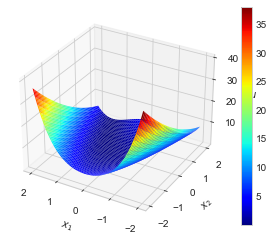

In [8]:
# a. grilles
x1_vec = np.linspace(-2,2,500)
x2_vec = np.linspace(-2,2,500)
x1_grid,x2_grid = np.meshgrid(x1_vec,x2_vec,indexing='ij')
rosen_grid = _rosen(x1_grid,x2_grid)

# b. coeur du plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(x1_grid,x2_grid,rosen_grid,cmap=cm.jet)

# c. ajout de labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$u$')

# d. inversion des axes
ax.invert_xaxis()

# e. ajout de barre de couleurs
fig.colorbar(cs);

**Courbes de niveau:**

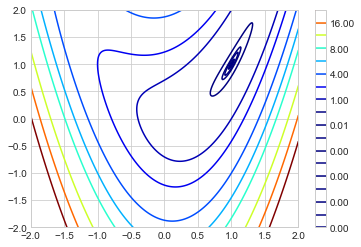

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
levels = [1e-6,5*1e-6,1e-5,5*1e-5,1e-4,5*1e-4,1e-3,5*1e-3,1e-2,5*1e-2,1,2,4,6,8,12,16,20]
cs = ax.contour(x1_grid,x2_grid,rosen_grid,levels=levels,cmap=cm.jet)
fig.colorbar(cs);

**Newton:**

In [11]:
x0 = np.array([5,4])
x,n = min_newton(rosen,x0,rosen_jac,rosen_hess)
print(n,x,rosen(x))

6 [1. 1.] 0.0


**Descente du gradient:**

In [13]:
x0 = np.array([5,4])
x,n = min_gradient_desc(rosen,x0,rosen_jac,alphas=[0.01,0.05,0.1,0.25,0.5,1])
print(n,x,rosen(x))

173 [1.00020519 1.00053964] 3.7750814497569406e-08


**Question:** comment faire converger plus vite la descente du gradient?

### Utilisation de scipy

**Préparation I:** fonction pour collecter l'information pendant l'optimisation:

In [14]:
# compliquée -> vous pouvez laisser la compréhension pour plus tard
def collect(x):
    
    # variables globales pour suivre les itérations
    global evals # poser evals = 0 avant d'appeler le solveur
    global x0
    global x1s
    global x2s
    global fs
    
    # a. initialisation d'une liste
    if evals == 0:
        x1s = [x0[0]] 
        x2s = [x0[1]]
        fs = [rosen(x0)]
        
    # b. ajout des valeurs essayées
    x1s.append(x[0])
    x2s.append(x[1])
    fs.append(rosen(x))
    
    # c. incrémentation du nombre des évaluations
    evals += 1
    

**Préparation II:** fonction pour le plot de l'information collectée:

In [17]:
# compliquée -> vous pouvez laisser la compréhension pour plus tard
def contour():
    
    global evals
    global x1s
    global x2s
    global fs
    
    # a. courbe de niveau
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(1,2,1)
    levels = [1e-6,5*1e-6,1e-5,5*1e-5,1e-4,5*1e-4,1e-3,5*1e-3,1e-2,5*1e-2,1,2,4,6,8,12,16,20]
    cs = ax.contour(x1_grid,x2_grid,rosen_grid,levels=levels,cmap=cm.jet)
    fig.colorbar(cs)
    ax.plot(x1s,x2s,'-o',ms=4,color='black')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    
    # b. valeur de la fonction
    ax = fig.add_subplot(1,2,2)
    ax.plot(np.arange(evals+1),fs,'-o',ms=4,color='black')
    ax.set_xlabel('itération')
    ax.set_ylabel('valeur de la fonction')
    

**Nelder-Mead**

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 57
         Function evaluations: 105


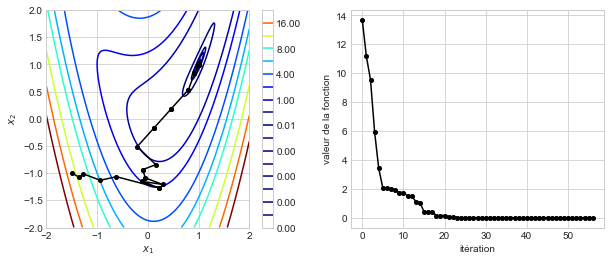

In [18]:
evals = 0 # var globale dans "collect"
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,
                           method='Nelder-Mead',
                           callback=collect, # appel de collect() avant chaque itération
                           options={'disp':True}) # affichage des résultats
contour()

> **Remarque**: le gradient n'est pas requis. Convergence lente à proximité de la cible.
>
> **Itérations:** combien d'étapes l'algorithme a demandé.
>
> **Évaluations de la fonction**: sera plus élevée que les itérations. Utilisés pour les calculs à l'étape suivante.

On peut aussi afficher l'information sur les résultats:

In [19]:
print(result)

 final_simplex: (array([[0.9999932 , 0.99998507],
       [1.00000809, 1.00003102],
       [1.00003176, 1.00007406]]), array([2.48761443e-11, 2.53004854e-10, 6.15284951e-10]))
           fun: 2.4876144250933352e-11
       message: 'Optimization terminated successfully.'
          nfev: 105
           nit: 57
        status: 0
       success: True
             x: array([0.9999932 , 0.99998507])


Et accéder à des résultats spécifiques

In [20]:
result.nit


57

**Newton** (avec hessienne analytique)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 12
         Hessian evaluations: 11


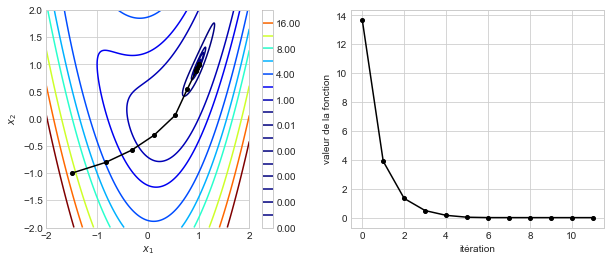

In [21]:
evals = 0 # variable globale dans "collect"
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,jac=rosen_jac,hess=rosen_hess,
                           method='Newton-CG',
                           callback=collect,
                           options={'disp':True})
contour()

> **Remarque**: plus lisse et rapide.

**Newton** (avec hessienne numérique calculée par scipy)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 36
         Hessian evaluations: 0


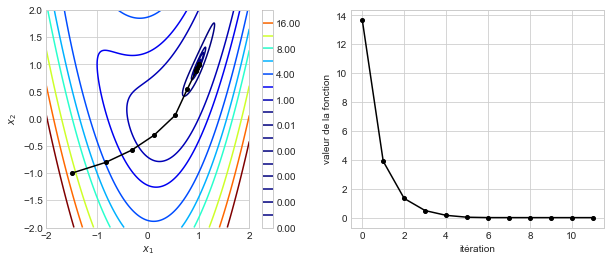

In [22]:
evals = 0 # global used in "collect"
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,jac=rosen_jac,
                           method='Newton-CG',
                           callback=collect,
                           options={'disp':True})
contour()

> **Remarque:** similaire au cas précédent, mais évaluations du gradient plutôt que de la hessienne.

**BFGS** (avec gradient analytique)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14


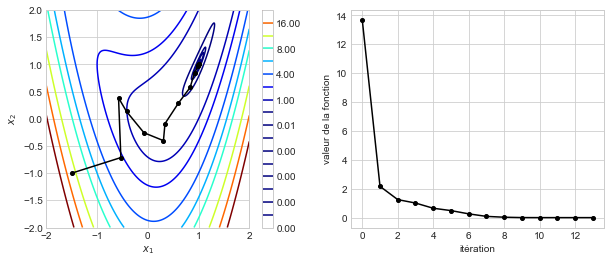

In [23]:
evals = 0 # variable globale dans "collect"
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,jac=rosen_jac,
                           method='BFGS',
                           callback=collect,
                           options={'disp':True})
contour()

> **Remarque**: peu lisse, mais rapide. Nombre très bas d'évaluations de la fonction.

**BFGS** (avec gradient numérique calculé par scipy)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 13
         Function evaluations: 42
         Gradient evaluations: 14


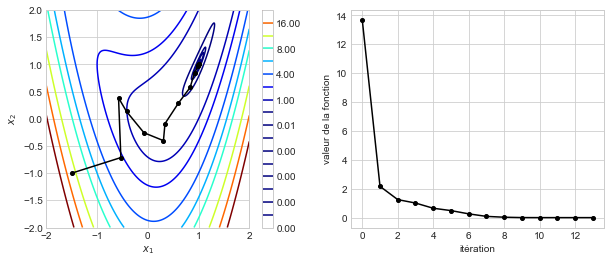

In [25]:
evals = 0 # variable globale dans "collect"
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0, # pas de jacobien spécifié
                           method='BFGS',
                           callback=collect,
                           options={'disp':True})
contour()

> **Remarque:** similaire au précédent, mais davantage d'évaluations de la fonction.

**L-BFGS-B** (avec gradient analytique)

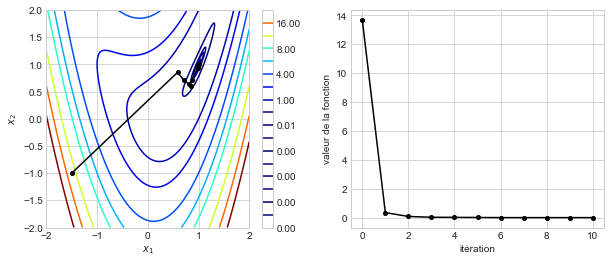

In [26]:
evals = 0 # variable globale dans "collect"
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,jac=rosen_jac,
                           method='L-BFGS-B',
                           bounds=((-3,3),(-3,3)),
                           callback=collect,
                           options={'disp':True})
contour()

**SLSQP**

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.7296908855910356e-09
            Iterations: 10
            Function evaluations: 13
            Gradient evaluations: 10


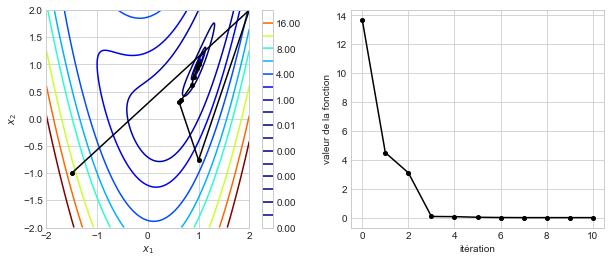

In [27]:
evals = 0 # variable globale dans "collect"
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,jac=rosen_jac,
                           method='SLSQP',
                           bounds=((-2,2),(-2,2)),
                           callback=collect,
                           options={'disp':True})
contour()

### Contrôler les solveurs

> **Remarque:** voir les réglages de chaque solveur [documention](https://docs.scipy.org/doc/scipy/reference/optimize.html).

On peut diminuer la **tolérance**:

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 14
         Function evaluations: 45
         Gradient evaluations: 15


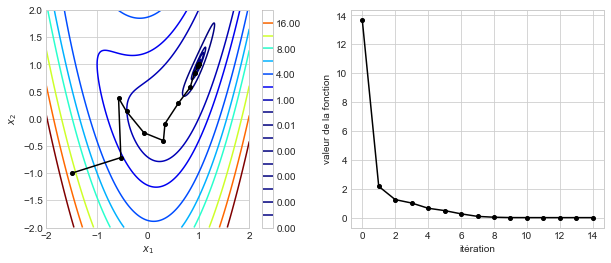

In [28]:
evals = 0
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,
                           method='BFGS',
                           callback=collect,
                           options={'disp':True,'gtol':1e-8}) # à remarquer ici
contour()

On peut modifier le **maximum d'itérations**:

         Current function value: 0.486266
         Iterations: 5
         Function evaluations: 18
         Gradient evaluations: 6


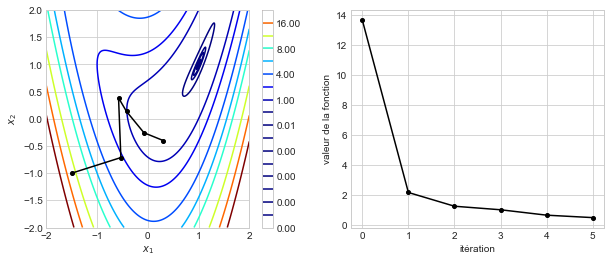

In [29]:
evals = 0
x0 = [-1.5,-1]
result = optimize.minimize(rosen,x0,
                           method='BFGS',
                           callback=collect,
                           options={'disp':True,'maxiter':5}) # remarquer ici et faire attention
contour()

**Question**: peut-on faire que le programme s'arrête si le maximum d'it"rations est trop bas?

### Fonction sombrero: minima locaux et multistart

Soit la fonction **sombrero**

$$
\begin{align*}
f(x_1,x_2) &= g\Big(\sqrt{x_1^2 + x_2^2}\Big)
\end{align*}
$$

où

$$
\begin{align*}
g(r) &= -\frac{\sin(r)}{r+10^{-4}} + 10^{-4}r^2
\end{align*}
$$

Le minimum global de cette fonction est $ (0,0) $. Mais la fonction a aussi des minima locaux (infiniment nombreux). Comment éviter cela?

In [30]:
def _sombrero(x1,x2):
    r = np.sqrt(x1**2 + x2**2)
    return -np.sin(r)/(r+1e-4) + 1e-4*r**2
    
sombrero = lambda x: _sombrero(x[0],x[1])

**Plot 3D**

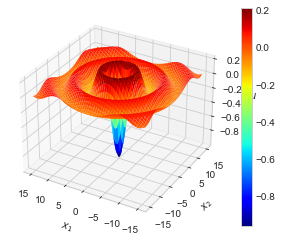

In [31]:
# a. grilles
x1_vec = np.linspace(-15,15,500)
x2_vec = np.linspace(-15,15,500)
x1_grid_sombrero,x2_grid_sombrero = np.meshgrid(x1_vec,x2_vec,indexing='ij')
sombrero_grid = _sombrero(x1_grid_sombrero,x2_grid_sombrero)

# b. coeur du plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(x1_grid_sombrero,x2_grid_sombrero,sombrero_grid,cmap=cm.jet)

# c. ajout d elabels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$u$')

# d. inversion des axes
ax.invert_xaxis()

# e. barre de couleurs
fig.colorbar(cs);

### Multi-start - BFGS

**Multi-start:** tirage aléatoire de plusieurs valeurs initiales:

In [33]:
np.random.seed(1986)
x0s = -15 + 30*np.random.uniform(size=(5000,2)) # compris dans [-15,15]
xs = np.empty((5000,2))
fs = np.empty(5000)

Essai pour résoudre avec **BFGS** en commençant à partir de chacune des valeurs:

In [34]:
fopt = np.inf
xopt = np.nan
for i,x0 in enumerate(x0s):
    
    # a. optimisation
    result = optimize.minimize(sombrero,x0,method='BFGS')
    xs[i,:] = result.x
    f = result.fun
    
    # b. affichage des 10 premières ou celle meilleures que celle déjà vues
    if i < 10 or f < fopt: # affichage des 10 premières ou s'il y a une amélioration
        if f < fopt:
            fopt = f
            xopt = xs[i,:]
            
        print(f'{i:4d}: x0 = ({x0[0]:6.2f},{x0[1]:6.2f})',end='')
        print(f' -> converge en ({xs[i][0]:6.2f},{xs[i][1]:6.2f}) avec f = {f:.14f}')
        
# meilleure solution
print(f'\nmeilleure solution:\n x = ({xopt[0]:6.2f},{xopt[1]:6.2f}) -> f = {fopt:.14f}')

   0: x0 = (  2.07,-12.68) -> converge en (  2.26,-13.84) avec f = -0.05118272212318
   1: x0 = (  3.25, 11.92) -> converge en (  3.69, 13.53) avec f = -0.05118272211068
   2: x0 = (  1.35,  6.08) -> converge en (  1.67,  7.53) avec f = -0.12241421149687
   3: x0 = ( -3.42,  4.55) -> converge en ( -4.63,  6.17) avec f = -0.12241421149362
   4: x0 = (  5.70,  6.56) -> converge en (  5.06,  5.82) avec f = -0.12241421149695
   5: x0 = (  5.71,  9.20) -> converge en (  4.06,  6.56) avec f = -0.12241421146805
   6: x0 = ( -6.49,  7.73) -> converge en ( -4.96,  5.91) avec f = -0.12241421149702
   7: x0 = ( -5.77, -1.86) -> converge en ( -7.34, -2.37) avec f = -0.12241421135593
   8: x0 = (  1.58, -2.01) -> converge en (  0.04, -0.05) avec f = -0.99776236017000
   9: x0 = (  2.33, 11.77) -> converge en (  2.72, 13.76) avec f = -0.05118272212317
  25: x0 = (  1.41, -3.37) -> converge en (  0.03, -0.06) avec f = -0.99776236017097
 150: x0 = (-14.53,  8.53) -> converge en ( -0.06,  0.03) avec f 

Le solveur converge de manière erronée vers plusieurs des minima locaux:

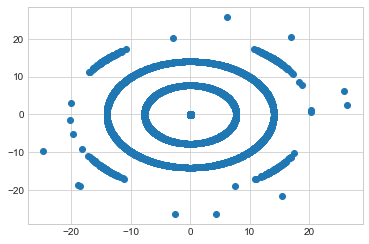

In [35]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(xs[:,0],xs[:,1]);

### Multi-start - Nelder-Mead

Essai pour résoudre avec la méthode de **Nelder-Mead** en commençant à partir de chacune des valeurs:

In [36]:
fopt = np.inf
xopt = np.nan
for i,x0 in enumerate(x0s):
    
    # a. optimisation
    result = optimize.minimize(sombrero,x0,method='Nelder-Mead')
    xs[i,:] = result.x
    f = result.fun
    
    # b. affichage des 10 premières ou celle meilleures que celle déjà vues
    if i < 10 or f < fopt: # affichage des 10 premières ou s'il y a une amélioration
        if f < fopt:
            fopt = f
            xopt = xs[i,:]
        print(f'{i:4d}: x0 = ({x0[0]:6.2f},{x0[1]:6.2f})',end='')
        print(f' -> converge en ({xs[i][0]:6.2f},{xs[i][1]:6.2f}) avec f = {f:.12f}')

# meilleure solution
print(f'\nmeilleure solution:\n x = ({xopt[0]:6.2f},{xopt[1]:6.2f}) -> f = {fopt:.12f}')

   0: x0 = (  2.07,-12.68) -> converge en (  2.20,-13.85) avec f = -0.051182722123
   1: x0 = (  3.25, 11.92) -> converge en (  3.43, 13.60) avec f = -0.051182722123
   2: x0 = (  1.35,  6.08) -> converge en (  1.39,  7.59) avec f = -0.122414211497
   3: x0 = ( -3.42,  4.55) -> converge en ( -3.71,  6.76) avec f = -0.122414211497
   4: x0 = (  5.70,  6.56) -> converge en (  6.69,  3.84) avec f = -0.122414211497
   5: x0 = (  5.71,  9.20) -> converge en (  4.98, 13.11) avec f = -0.051182722123
   6: x0 = ( -6.49,  7.73) -> converge en ( -7.34,  2.37) avec f = -0.122414211497
   7: x0 = ( -5.77, -1.86) -> converge en ( -7.45, -2.01) avec f = -0.122414211497
   8: x0 = (  1.58, -2.01) -> converge en ( -0.02,  0.06) avec f = -0.997762360171
   9: x0 = (  2.33, 11.77) -> converge en (  2.36, 13.83) avec f = -0.051182722123

meilleure solution:
 x = ( -0.02,  0.06) -> f = -0.997762360171


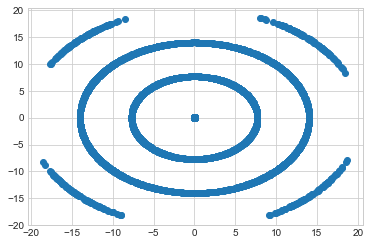

In [37]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(xs[:,0],xs[:,1]);

### Y-a-t-il de meilleures solutions que multi-start?

**Pour faire bref:** Non.

**Améliorations potentielles:** utiliser l'information de l'execution précédente pour déterminer où chercher ensuite. Arbitrage fondamental entre:

1. **Exploitation.** chercher dans des zones où les évaluations précédentes ont donné des valeurs basse lors des évaluations de la fonction.
2. **Exploration.** chercher dans des zones nouvelles. 

**Heuristique:** si le même optimum est obtenu à partir de plusieurs valeurs initiales, c'est un bon signe pour ce ce soit l'optimum global.

**Discussion supplémentaire**: [Benchmarking Global Optimizers](https://fguvenendotcom.files.wordpress.com/2019/09/agk2019-september-nber-submit.pdf) ([code](https://github.com/serdarozkan/TikTak#tiktak))

### <center> CONTRAINTES </center>

### En général

En considère le problème sous des contraintes suivant

$$
\begin{align*}
\min_{x_1,x_2,x_3,x_4} x_1x_4(x_1+x_2+x_3) + x_3
\end{align*}
$$

sous les contraintes:

$$
\begin{align*}
x_1x_2x_3x_4 &\geq 25 \\
x_1^2+x_2^2+x_3^2+x_4^2 &= 40 \\
1 \leq x_1,x_2,x_3,x_4 &\leq 5
\end{align*}
$$

On définit la fonction objectif et des contraintes:

In [38]:
def _objective(x1,x2,x3,x4):
    return x1*x4*(x1+x2+x3)+x3

def objective(x):
    return _objective(x[0],x[1],x[2],x[3])

def ineq_constraint(x):
    return x[0]*x[1]*x[2]*x[3]-25.0 # non satisfaite si negative

def eq_constraint(x):
    sum_eq = 40.0
    for i in range(4):
        sum_eq = sum_eq - x[i]**2
    return sum_eq # doit être égale à zéro

In [39]:
# a. mise en place
bound = (1.0,5.0)
bounds = (bound, bound, bound, bound)
ineq_con = {'type': 'ineq', 'fun': ineq_constraint} 
eq_con = {'type': 'eq', 'fun': eq_constraint}

# b. appel du solveur
x0 = (40**(1/8),40**(1/8),40**(1/8),40**(1/8)) # contrainte d'égalité
result = optimize.minimize(objective,x0,
                             method='SLSQP',
                             bounds=bounds,
                             constraints=[ineq_con,eq_con],
                             options={'disp':True})

print('\nx = ',result.x)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 17.014017289043334
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9

x =  [1.         4.74299963 3.82115    1.37940829]


**Alternative**: développer la fonction objectif en incluant une pénalité, avec des valeurs initiales qui se trouvent en dehors des bornes permises et des contraintes sont projetées sur la zone/région permise, mais une pénalité(importante/élevée) est ajouté afin de décourager cela. Le problème est résolu avec un solveur sans contraintes.

### Application économique: un modèle de consommation et épargne

Soit le **problème de consommation-épargne** suivant:

$$
\begin{align*}
V(a_0) &= \max_{c_1,c_2,c_3} \frac{c_{1}^{1-\rho}}{1-\rho} + \beta \frac{c_{2}^{1-\rho}}{1-\rho} + \beta^2\frac{c_{3}^{1-\rho}}{1-\rho} + \beta^2\nu\frac{(a_{3}+\kappa)^{1-\rho}}{1-\rho}\\
\text{s.t.} \\
&\text{s.t.}&\\
m_1 &= (1+r)a_0 + y_1\\
a_1 &= m_1-c_1\\
m_2 &= (1+r)a_1 + y_2\\
a_2 &= m_2-c_2\\
m_3 &= (1+r)a_2 + y_3\\
a_3 &= m_3-c_3\\
c_1,c_2,c_3 &\geq 0\\
a_1,a_2,a_3 &\geq 0\\
\end{align*}
$$

où

* $m_t$ sont le liquidités  disponibles en $t\in\{1,2,\dots,T\}$
* $c_t$ est la consommation en $t$
* $a_t$ sont le revenu et les actifs à la fin de la période $t$
* ${y_t}$ est le revenu en $t$
* $\beta > 0$ est le facteur d'actualisation
* $r > -1$ est le taux d'intérêt
* $\rho > 1$ est le coefficient CRRA
* $\nu > 0 $ est la force des souhaits de legs
* $\kappa > 0$ est le degré d'importance du luxe dans les souhaits de legs
* $a_t\geq0$ est une contrainte d'absence d'emprunt.


**Guide pour résoudre ce type de problèmes:**

1. Régler les paramètres
2. Spécifier/écrire la fonction objectif
3. Déterminer la manière de prendre en compte les contraintes
4. Appel d'un solveur approprié

**Paramètres:**

In [ ]:
par = SimpleNamespace()
par.a0 = 0.5
par.beta = 0.94
par.r = 0.04
par.rho = 8
par.kappa = 0.5
par.nu = 0.1
par.y = [1,2,4]
par.T = 3

**Fonction objectif**:

In [ ]:
def obj(c,par,full_return=False):
    
    # fonction objectif avec une pénalité
    
    # a. affectations
    a = np.zeros(par.T) # actifs en fin de période
    m = np.zeros(par.T) # liquidités
    cb = np.zeros(par.T) # bornés
    
    # b. bornes sur la consommation et pénalité
    penalty = 0.0
    for t in range(par.T):
        
        # i. "lag" des actifs 
        a_lag = a[t-1] if t > 0 else par.a0
        
        # ii. liquidités
        m[t] = (1+par.r)*a_lag + par.y[t]
        
        # ii. consommation bornée
        if c[t] < 0:
            penalty += 10_000*np.abs(c[t]-0.0)
            cb[t] = 0
        elif c[t] > m[t]:
            penalty += 10_000*np.abs(c[t]-m[t])
            cb[t] = m[t]
        else:
            cb[t] = c[t]
        
        # d. actifs en fin de période
        a[t] = m[t] - cb[t]
            
    # c. utilité
    utility = 0.0
    
    # i. consommation
    for t in range(par.T):
        utility += par.beta**t*(cb[t]**(1-par.rho))/(1-par.rho)
    
    # ii. legs
    utility += par.beta**(par.T-1)*par.nu*(a[-1]+par.kappa)**(1-par.rho)/(1-par.rho)
        
    # d. renvoi de l'utilité négative + la pénalité
    if full_return:
        return utility,m,a
    else:
        return -utility + penalty

**Résolution**:

In [ ]:
def solve(par):
    
    # a. valeurs initiales
    x0 = [par.a0/par.T,par.a0/par.T,par.a0/par.T]
    
    # b. solveur
    results = optimize.minimize(obj,x0,args=(par,),method='nelder-mead')
    assert results.success
    print(f'solved in {results.nit} iteratoons [{results.nfev} function evaluations]')
    
    # c. détails
    c = results.x
    utility,m,a = obj(c,par,full_return=True)
    print(f't = 0: a = {par.a0:.4f}')
    for t in range(par.T):
        print(f't = {t+1}: y = {par.y[t]:.4f}, m = {m[t]:.4f}, c = {c[t]:.4f}, a = {a[t]:.4f}')    
    print(f'utility = {utility:.8f}')

In [ ]:
solve(par)